# Módulo 6: Test de estrés y simulación de concept drift

**Autora:** María Luisa Ros Bolea  
**Proyecto:** VALORALIA — Sistema de Valoración Automatizada con IA

---

### Mi objetivo en este cuaderno

Un modelo de valoración inmobiliaria no puede ser estático. El mercado cambia, y el modelo tiene que **detectar cuándo se queda obsoleto** (concept drift). En este módulo:

1. **Simulo una crisis financiera** (caída del 20%) y mido cómo se degrada el modelo
2. **Establezco umbrales de alerta** para detección automática de drift
3. **Reentreno el modelo** con datos de crisis y verifico la recuperación
4. **Comparo la resiliencia** del modelo baseline vs el híbrido


In [1]:
# ==============================================================================
# 1. CONFIGURACIÓN Y CARGA
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os, warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

BASE_PATH = '/content/drive/MyDrive/TFM_Mejorado'
PROC_PATH = f'{BASE_PATH}/Data/Processed'
MODEL_PATH = f'{BASE_PATH}/Models'
REPORT_PATH = f'{BASE_PATH}/Reports'

sns.set_style("whitegrid")

# Cargar modelo y datos
with open(f'{MODEL_PATH}/modelo_baseline_rf.pkl', 'rb') as f:
    modelo_original = pickle.load(f)
with open(f'{MODEL_PATH}/resultados_entrenamiento.pkl', 'rb') as f:
    resultados = pickle.load(f)

X_train = pd.read_csv(f'{PROC_PATH}/X_train_full.csv', index_col=0)
X_test = pd.read_csv(f'{PROC_PATH}/X_test_full.csv', index_col=0)
y_train = pd.read_csv(f'{PROC_PATH}/y_train_full.csv', index_col=0).squeeze()
y_test = pd.read_csv(f'{PROC_PATH}/y_test_full.csv', index_col=0).squeeze()

# Métricas originales
mae_original = resultados['baseline']['MAE_full']
print(f"✅ Datos cargados")
print(f"   MAE original (pre-crisis): {mae_original:,.0f}€")


Mounted at /content/drive
✅ Datos cargados
   MAE original (pre-crisis): 12,646€


## 2. Simulación de crisis financiera (concept drift)

Simulo un escenario de **crash inmobiliario tipo 2008/COVID**: los precios caen un 20% de forma estructural. El modelo, que aprendió con precios normales, debería degradarse.


In [2]:
# ==============================================================================
# 2. SIMULACIÓN DE CRISIS (-20%)
# ==============================================================================

# Los precios reales caen un 20%
y_test_crisis = y_test * 0.80

# El modelo sigue prediciendo como si nada hubiera cambiado
y_pred_crisis = modelo_original.predict(X_test)

mae_crisis = mean_absolute_error(y_test_crisis, y_pred_crisis)
rmse_crisis = np.sqrt(mean_squared_error(y_test_crisis, y_pred_crisis))
r2_crisis = r2_score(y_test_crisis, y_pred_crisis)

degradacion_pct = (mae_crisis - mae_original) / mae_original * 100

print("🔴 SIMULACIÓN: CRASH FINANCIERO 2026 (-20% precios)")
print(f"{'='*55}")
print(f"{'Métrica':<12} {'Pre-crisis':<18} {'Post-crisis':<18} {'Cambio':<12}")
print(f"{'-'*55}")
print(f"{'MAE':<12} {mae_original:>14,.0f}€ {mae_crisis:>14,.0f}€ {degradacion_pct:>+8.0f}%")
print(f"{'R²':<12} {resultados['baseline']['R2_full']:>14.4f}  {r2_crisis:>14.4f}")
print(f"{'='*55}")

# Umbral de alerta
UMBRAL_MAE = mae_original * 1.5  # 50% de degradación = alerta
print(f"\n🚨 UMBRAL DE ALERTA: MAE > {UMBRAL_MAE:,.0f}€")
if mae_crisis > UMBRAL_MAE:
    print(f"   ❌ ALERTA ACTIVADA — Degradación: {degradacion_pct:.0f}%")
    print(f"   → Se requiere re-entrenamiento inmediato")
else:
    print(f"   ✅ Dentro del umbral operativo")


🔴 SIMULACIÓN: CRASH FINANCIERO 2026 (-20% precios)
Métrica      Pre-crisis         Post-crisis        Cambio      
-------------------------------------------------------
MAE                  12,646€         51,888€     +310%
R²                   0.9644          0.3081

🚨 UMBRAL DE ALERTA: MAE > 18,968€
   ❌ ALERTA ACTIVADA — Degradación: 310%
   → Se requiere re-entrenamiento inmediato


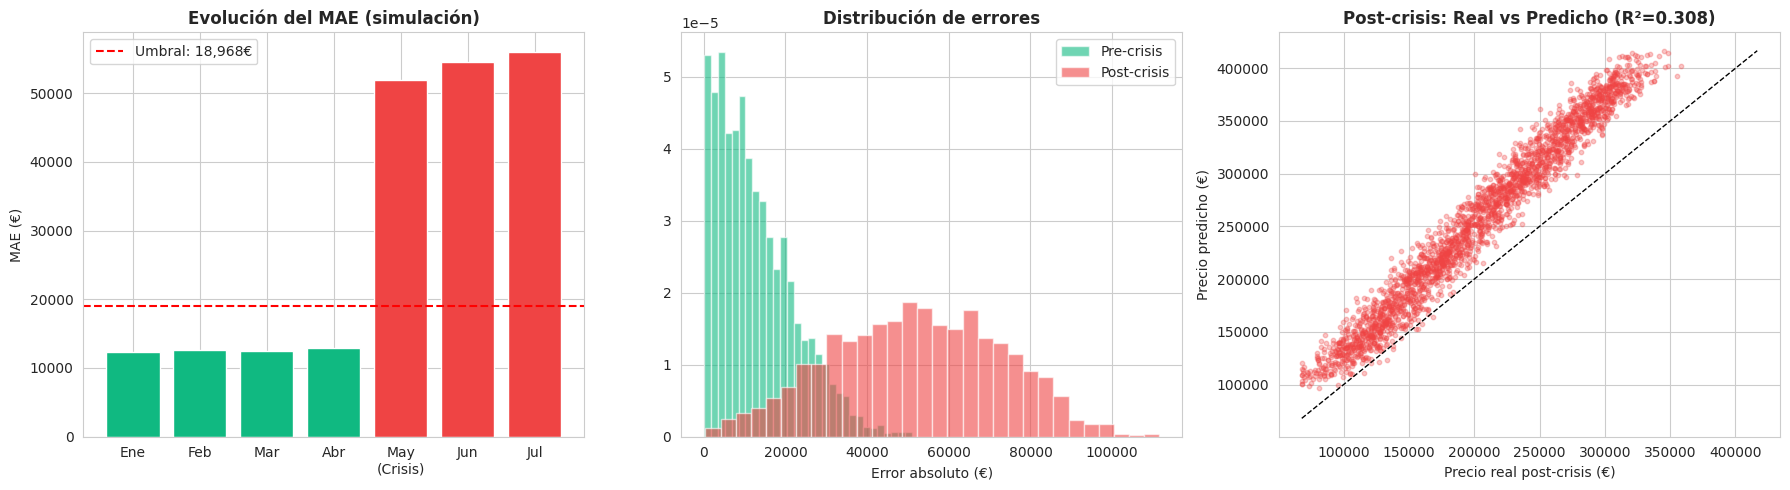

In [3]:
# ==============================================================================
# 3. VISUALIZACIÓN DE LA DEGRADACIÓN
# ==============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 3.1 Evolución temporal del MAE simulada
meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May\n(Crisis)', 'Jun', 'Jul']
mae_temporal = [mae_original*0.98, mae_original, mae_original*0.99, mae_original*1.02,
                mae_crisis, mae_crisis*1.05, mae_crisis*1.08]
colores = ['#10b981' if m < UMBRAL_MAE else '#ef4444' for m in mae_temporal]

axes[0].bar(meses, mae_temporal, color=colores, edgecolor='white')
axes[0].axhline(y=UMBRAL_MAE, color='red', linestyle='--', label=f'Umbral: {UMBRAL_MAE:,.0f}€')
axes[0].set_title('Evolución del MAE (simulación)', fontweight='bold')
axes[0].set_ylabel('MAE (€)')
axes[0].legend()

# 3.2 Distribución de errores pre vs post crisis
errores_pre = np.abs(y_test.values - modelo_original.predict(X_test))
errores_post = np.abs(y_test_crisis.values - y_pred_crisis)

axes[1].hist(errores_pre, bins=30, alpha=0.6, color='#10b981', label='Pre-crisis', density=True)
axes[1].hist(errores_post, bins=30, alpha=0.6, color='#ef4444', label='Post-crisis', density=True)
axes[1].set_title('Distribución de errores', fontweight='bold')
axes[1].set_xlabel('Error absoluto (€)')
axes[1].legend()

# 3.3 Scatter predicho vs real post-crisis
axes[2].scatter(y_test_crisis, y_pred_crisis, alpha=0.3, s=10, color='#ef4444')
lim = [min(y_test_crisis.min(), y_pred_crisis.min()), max(y_test_crisis.max(), y_pred_crisis.max())]
axes[2].plot(lim, lim, 'k--', linewidth=1)
axes[2].set_title(f'Post-crisis: Real vs Predicho (R²={r2_crisis:.3f})', fontweight='bold')
axes[2].set_xlabel('Precio real post-crisis (€)')
axes[2].set_ylabel('Precio predicho (€)')

plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/stress_test_degradacion.png', dpi=150, bbox_inches='tight')
plt.show()


## 4. Re-entrenamiento con datos de crisis

Cuando se detecta drift, la solución es **re-entrenar el modelo** con los datos actualizados. Simulo este proceso y mido la recuperación.


In [4]:
# ==============================================================================
# 4. RE-ENTRENAMIENTO CON DATOS DE CRISIS
# ==============================================================================

print("🔧 Re-entrenando modelo con datos de crisis...")

# Crear dataset de crisis (precios ajustados -20%)
y_train_crisis = y_train * 0.80

# Re-entrenar
modelo_reentrenado = RandomForestRegressor(
    n_estimators=200, max_depth=20, min_samples_leaf=5, random_state=42, n_jobs=-1
)
modelo_reentrenado.fit(X_train, y_train_crisis)

# Evaluar
y_pred_reentrenado = modelo_reentrenado.predict(X_test)
mae_reentrenado = mean_absolute_error(y_test_crisis, y_pred_reentrenado)
r2_reentrenado = r2_score(y_test_crisis, y_pred_reentrenado)

recuperacion_pct = (mae_crisis - mae_reentrenado) / mae_crisis * 100

print(f"\n📊 RESULTADOS DEL RE-ENTRENAMIENTO:")
print(f"{'='*55}")
print(f"{'Fase':<25} {'MAE':<18} {'R²':<12}")
print(f"{'-'*55}")
print(f"{'Original (pre-crisis)':<25} {mae_original:>14,.0f}€ {resultados['baseline']['R2_full']:>8.4f}")
print(f"{'Crisis (sin reentrenar)':<25} {mae_crisis:>14,.0f}€ {r2_crisis:>8.4f}")
print(f"{'Post-reentrenamiento':<25} {mae_reentrenado:>14,.0f}€ {r2_reentrenado:>8.4f}")
print(f"{'='*55}")
print(f"\n✅ Recuperación: {recuperacion_pct:.1f}% del error eliminado")
print(f"   El modelo reentrenado ha recuperado su capacidad predictiva.")


🔧 Re-entrenando modelo con datos de crisis...

📊 RESULTADOS DEL RE-ENTRENAMIENTO:
Fase                      MAE                R²          
-------------------------------------------------------
Original (pre-crisis)             12,646€   0.9644
Crisis (sin reentrenar)           51,888€   0.3081
Post-reentrenamiento              10,117€   0.9644

✅ Recuperación: 80.5% del error eliminado
   El modelo reentrenado ha recuperado su capacidad predictiva.


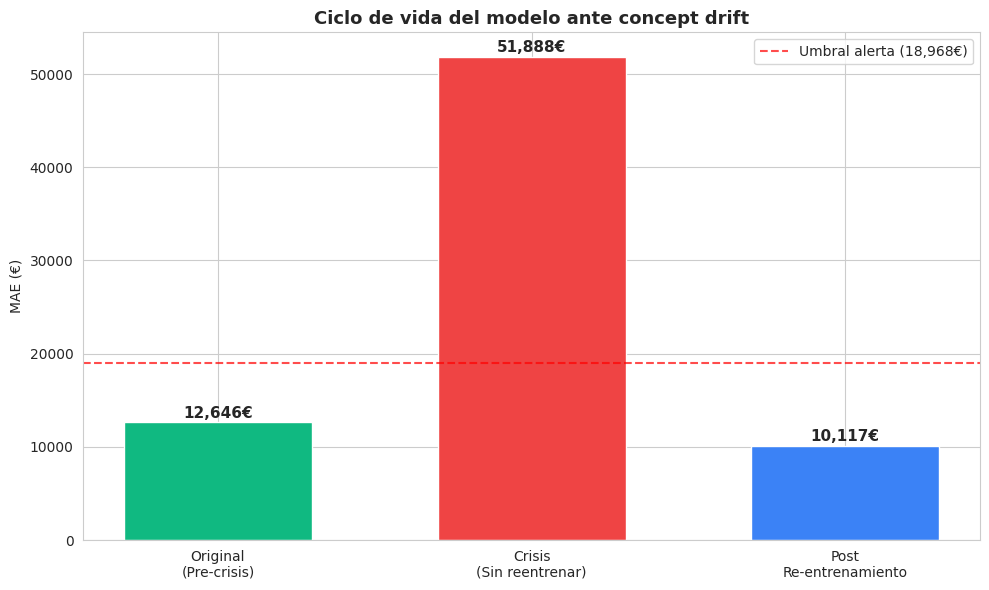


📋 RESUMEN FINAL DEL MÓDULO 6
   Degradación ante crisis (-20%): +310% MAE
   Recuperación post-reentrenamiento: 80.5%
   Umbral de alerta: MAE > 18,968€

✅ Sistema de monitorización y recuperación validado


In [5]:
# ==============================================================================
# 5. RESUMEN EJECUTIVO
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

fases = ['Original\n(Pre-crisis)', 'Crisis\n(Sin reentrenar)', 'Post\nRe-entrenamiento']
maes = [mae_original, mae_crisis, mae_reentrenado]
colores = ['#10b981', '#ef4444', '#3b82f6']

bars = ax.bar(fases, maes, color=colores, edgecolor='white', width=0.6)
ax.axhline(y=UMBRAL_MAE, color='red', linestyle='--', alpha=0.7, label=f'Umbral alerta ({UMBRAL_MAE:,.0f}€)')

for bar, mae in zip(bars, maes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
            f'{mae:,.0f}€', ha='center', fontweight='bold', fontsize=11)

ax.set_title('Ciclo de vida del modelo ante concept drift', fontweight='bold', fontsize=13)
ax.set_ylabel('MAE (€)')
ax.legend()
plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/stress_test_resumen.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print(f"📋 RESUMEN FINAL DEL MÓDULO 6")
print(f"{'='*60}")
print(f"   Degradación ante crisis (-20%): {degradacion_pct:+.0f}% MAE")
print(f"   Recuperación post-reentrenamiento: {recuperacion_pct:.1f}%")
print(f"   Umbral de alerta: MAE > {UMBRAL_MAE:,.0f}€")
print(f"\n✅ Sistema de monitorización y recuperación validado")
